In [40]:
import numpy as np
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Load the dataset
import pickle

import numpy as np
import matplotlib.pyplot as plt
import random

import scipy.sparse as sp
 
import pickle
from scipy.sparse import csr_matrix

from scipy.sparse import eye
from scipy.sparse.linalg import inv
import signal



colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from scipy.sparse import random as sparse_random

import time

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix, csgraph
from scipy.sparse.linalg import inv
from numpy.linalg import pinv

from data_loader import *

from sparsify import *

from appr import *
from RelaxReg import *

import multiprocessing
import time

In [41]:
dataset_list = ['political-blog']#, 'citeseer', 'cora' ]#, 'mnist-tr-nei10', 'pubmed', 'blogcatalog']#, 'youtube', 'ogbn-arxiv']


In [42]:
"""

n = 25

adj_matrix = (np.random.rand(n,n) < .25).astype(float)
adj_matrix = adj_matrix * np.random.rand(n,n)
adj_matrix= adj_matrix + adj_matrix.T
np.fill_diagonal(adj_matrix, 0)


adj_matrix = csr_matrix(adj_matrix)   

degree_vector = np.asarray(adj_matrix.sum(axis=1)).flatten()


alpha = 0.1


y = np.random.randn(n)
xpinv,_,_ = ppr_solve(adj_matrix,degree_vector, alpha, y, timed = False)

x = np.zeros(n)
err_r = np.zeros(n)
for s in range(n):
    xs,r,volr, miter = appr(adj_matrix,degree_vector, maxneighbors = 10,
                         epsilon = 0.001/n, alpha= alpha, s = s,maxiter = 100)
    x = x + xs * y[s]
    err_r[s] = np.linalg.norm(r,1)


plt.subplot(2,1,1)

xerr = x-xpinv
plt.plot(xerr,'r:')
plt.subplot(2,1,2)
plt.plot(err_r,'g')

plt.tight_layout()

"""


"\n\nn = 25\n\nadj_matrix = (np.random.rand(n,n) < .25).astype(float)\nadj_matrix = adj_matrix * np.random.rand(n,n)\nadj_matrix= adj_matrix + adj_matrix.T\nnp.fill_diagonal(adj_matrix, 0)\n\n\nadj_matrix = csr_matrix(adj_matrix)   \n\ndegree_vector = np.asarray(adj_matrix.sum(axis=1)).flatten()\n\n\nalpha = 0.1\n\n\ny = np.random.randn(n)\nxpinv,_,_ = ppr_solve(adj_matrix,degree_vector, alpha, y, timed = False)\n\nx = np.zeros(n)\nerr_r = np.zeros(n)\nfor s in range(n):\n    xs,r,volr, miter = appr(adj_matrix,degree_vector, maxneighbors = 10,\n                         epsilon = 0.001/n, alpha= alpha, s = s,maxiter = 100)\n    x = x + xs * y[s]\n    err_r[s] = np.linalg.norm(r,1)\n\n\nplt.subplot(2,1,1)\n\nxerr = x-xpinv\nplt.plot(xerr,'r:')\nplt.subplot(2,1,2)\nplt.plot(err_r,'g')\n\nplt.tight_layout()\n\n"

In [43]:
ntrials = 10

for dataset in dataset_list:    
    adj_matrix_orig, labels = load_graph_data(dataset)     
    n = len(labels)
    y_nnz_len = n
    for trial in range(ntrials):
        ystring = 'yvec_n%d_nnz%d_trial%d' % (n,y_nnz_len,trial)
        
        try:
            out = pickle.load(open('y_rhs/%s.pkl' % ystring,'rb'))

        except:
            print(ystring)
 
 
            y_nnz = np.random.randn(y_nnz_len)
            nnz_idx = np.random.choice(n, y_nnz_len, replace=False)
            y = np.zeros(n)
            y[nnz_idx] = y_nnz

            out = {'y_nnz':y_nnz,'nnz_idx':nnz_idx, 'y':csr_matrix(y)}
            pickle.dump(out, open('y_rhs/%s.pkl' % ystring,'wb'))




In [53]:





trial = 0
beta = 0.25
alpha = 1 - 2*beta

epsilon_vec = [1.e-1,1.e-2,1.e-3,1.e-4,1.e-5]
epsilon_vec = [.1,.01,0.001,0.0001]

for dataset in dataset_list:
    
    
    adj_matrix_orig, labels = load_graph_data(dataset)
    
    

    
    if not isinstance(adj_matrix_orig, csr_matrix):
        adj_matrix_orig = csr_matrix(adj_matrix_orig)   
        adj_matrix_orig.eliminate_zeros()       
    n = len(labels)
    y_nnz_len = n
    num_classes = max(labels)+1
    
    
    
    mat = {}
    
    
    
    
    for sparselevel in [2,1,.5]:#,.1]:#[2,1,.5,.1]: 
        for sparse in ['orig','influencer','uniform','resistive']:
            
            if n > 10000 and sparse == 'resistive': continue
            if not (sparse == 'orig'):
                node_degrees = adj_matrix_orig.getnnz(axis=1)
                c = int(np.round(np.mean(node_degrees)*sparselevel))
                if c == 0: continue

                if sparse == 'influencer':
                    spmat_string = '%s_sparse%s_c%d_spmat' % (dataset,sparse,c)
                else:
                    p = np.round(100*mat['influencer'].nnz / mat['orig'].nnz)/100
                    spmat_string = '%s_sparse%s_p%f_spmat' % (dataset,sparse,p)



                adj_matrix = pickle.load(open('offline_sparsify/%s.pkl' % spmat_string,'rb'))
            else:
                adj_matrix = adj_matrix_orig
                
            
            if not isinstance(adj_matrix, csr_matrix):
                adj_matrix = csr_matrix(adj_matrix)   
                adj_matrix.eliminate_zeros()  
            
           
            
            mat[sparse] = adj_matrix     
            degree_vector = np.asarray(adj_matrix.sum(axis=1)).flatten()


            for epsilon in epsilon_vec:

                if sparse == 'orig':
                    expstring = '%s_beta%f_sparse%s_eps%e_ynnz%d' % (dataset,beta,'orig',epsilon,y_nnz_len)
                elif sparse == 'influencer':
                    expstring = '%s_beta%f_sparse%s_c%d_eps%e_ynnz%d' % (dataset,beta,sparse,c,epsilon,y_nnz_len)
                else:
                    expstring = '%s_beta%f_sparse%s_p%f_eps%e_ynnz%d' % (dataset,beta,sparse,p,epsilon,y_nnz_len)

                print(expstring,adj_matrix.nnz)


                try:

                    out = pickle.load(open('offline_APPR/%s.pkl' % expstring,'rb'))

                except:





                    #def run_stuff(qu): 
                    ystring = 'yvec_n%d_nnz%d_trial%d' % (n,y_nnz_len,trial)

                    out = pickle.load(open('y_rhs/%s.pkl' % ystring,'rb'))

                    y_nnz = out['y_nnz']
                    y = out['y']
                    nnz_idx = out['nnz_idx']






                    #xpinv = ppr_solve(adj_matrix,degree_vector, alpha, y)
                    start = time.time()
                    x = np.zeros(n)
                    maxiters = np.zeros(n)
                    err_r = np.zeros(n)
                    volrs = []
                    supprs = []
                    num_ops_list = []
                    for i,s in enumerate(nnz_idx):

                        if i% 1000 == 0:
                            print(i, len(nnz_idx))
                        num_ops = [0]
                        xs,r,volr,suppr, maxiter = appr(adj_matrix,degree_vector, num_ops=num_ops, epsilon = epsilon, alpha= alpha, s = s,maxiter = 100)
                        volrs.append(np.array(volr))
                        supprs.append(np.array(suppr))
                        num_ops_list.append(num_ops[0])
                        maxiters[s] = maxiter
                        x = x + xs * y_nnz[i]

                        err_r[s] = np.linalg.norm(r,1) 
                    runtime = time.time() - start
                    print(np.array(num_ops_list))
                     

                    r = ppr_getres(adj_matrix,degree_vector,alpha,x,y)
                    r_orig = ppr_getres(adj_matrix_orig,degree_vector,alpha,x,y)

                    out  = {'y':y,'x':x,'r':r,'r_orig':r_orig,
                            'err_r':err_r,'runtime':runtime,
                            'maxiters':maxiters,'volrs':volrs,'supprs':supprs,
                           'num_ops_list':np.array(num_ops_list)}
                    pickle.dump(out, open('offline_APPR/%s.pkl' % expstring,'wb'))

                    #qu.put(True)
                    
                     
                print(epsilon, np.linalg.norm(out['r'],1),np.linalg.norm(out['r_orig'],1),np.linalg.norm(out['err_r'],1), out['runtime'] )


asdf

political-blog_beta0.250000_sparseorig_eps1.000000e-01_ynnz1222 33431
0.1 3.649856186596888 3.649856186596888 926.09765625 0.21702075004577637
political-blog_beta0.250000_sparseorig_eps1.000000e-02_ynnz1222 33431
0.01 3.0164749861703632 3.0164749861703632 512.7337334027382 0.5928049087524414
political-blog_beta0.250000_sparseorig_eps1.000000e-03_ynnz1222 33431
0.001 1.0042132585319623 1.0042132585319623 349.28096178291185 1.4426453113555908
political-blog_beta0.250000_sparseorig_eps1.000000e-04_ynnz1222 33431
0 1222
1000 1222
[36 21 18 ... 36 22 22]
0.0001 0.2629533496020865 0.2629533496020865 211.67186686370147 7.663399696350098
political-blog_beta0.250000_sparseinfluencer_c55_eps1.000000e-01_ynnz1222 20007
0.1 3.3960279585221587 3.2779773332816733 963.395670978803 0.16637945175170898
political-blog_beta0.250000_sparseinfluencer_c55_eps1.000000e-02_ynnz1222 20007
0.01 3.4109921565208 3.2994133733289606 643.5249702389945 0.4317591190338135
political-blog_beta0.250000_sparseinfluencer_c

NameError: name 'asdf' is not defined

In [48]:

for dataset in dataset_list:
    
    
    adj_matrix, labels = load_graph_data(dataset)
    if not isinstance(adj_matrix, csr_matrix):
        adj_matrix = csr_matrix(adj_matrix_orig)   
        adj_matrix.eliminate_zeros()       
    n = len(labels)
    y_nnz_len = n
    num_classes = max(labels)+1
    
    
    for sparselevel in [2,1,.5]: 

        node_degrees = adj_matrix.getnnz(axis=1)
        maxneighbors = int(np.round(np.mean(node_degrees)*sparselevel))
        print(maxneighbors)
        if maxneighbors == 0: continue
        degree_vector = np.asarray(adj_matrix.sum(axis=1)).flatten()





        for epsilon in [0.1,0.01,0.001,0.0001]: 
            expstring = '%s_beta%f_onlinesparse_c%d_eps%e_ynnz%d' % (dataset,beta,maxneighbors,epsilon,y_nnz_len)

            print(expstring,adj_matrix.nnz)


            try:
                
                out = pickle.load(open('offline_APPR/%s.pkl' % expstring,'rb'))

            except:






                ystring = 'yvec_n%d_nnz%d_trial%d' % (n,y_nnz_len,trial)

                out = pickle.load(open('y_rhs/%s.pkl' % ystring,'rb'))

                y_nnz = out['y_nnz']
                y = out['y']
                nnz_idx = out['nnz_idx']



                #xpinv = ppr_solve(adj_matrix,degree_vector, alpha, y)
                start = time.time()
                x = np.zeros(n)
                maxiters = np.zeros(n)
                err_r = np.zeros(n)
                volrs = []
                supprs = []
                num_ops_list = []
                    
                for i,s in enumerate(nnz_idx):


                    num_ops = [0]
                    xs,r,volr,suppr, maxiter = appr(adj_matrix,degree_vector, num_ops=num_ops, maxneighbors = maxneighbors,
                                                    epsilon = epsilon, alpha= alpha, s = s,maxiter = 100)
                    volrs.append(np.array(volr))
                    supprs.append(np.array(suppr))
                    num_ops_list.append(num_ops[0])
                    maxiters[s] = maxiter

                    x = x + xs * y_nnz[i]

                    err_r[s] = np.linalg.norm(r,1) 
                runtime = time.time() - start

                print(np.array(num_ops_list))
                
                r = ppr_getres(adj_matrix,degree_vector,alpha,x,y)

                out  = {'y':y,'x':x,'r':r,'err_r':err_r,'runtime':runtime,
                        'maxiters':maxiters,'volrs':volrs,'supprs':supprs,'num_ops_list':np.array(num_ops_list)}
                pickle.dump(out, open('offline_APPR/%s.pkl' % expstring,'wb'))

            print(epsilon, np.linalg.norm(out['r'],1),np.linalg.norm(out['err_r'],1), out['runtime'] )




55
political-blog_beta0.250000_onlinesparse_c55_eps1.000000e-01_ynnz1222 33431
[1 2 2 ... 0 1 1]
0.1 3.649856186596888 926.09765625 0.1574568748474121
political-blog_beta0.250000_onlinesparse_c55_eps1.000000e-02_ynnz1222 33431
[2 3 3 ... 0 2 3]
0.01 3.0164749861703632 512.7337334027382 0.5352632999420166
political-blog_beta0.250000_onlinesparse_c55_eps1.000000e-03_ynnz1222 33431
[9 6 7 ... 2 4 8]
0.001 1.0093204697878555 348.9712526479 1.4743030071258545
27
political-blog_beta0.250000_onlinesparse_c27_eps1.000000e-01_ynnz1222 33431
[1 2 2 ... 0 1 1]
0.1 3.649856186596888 926.09765625 0.17661070823669434
political-blog_beta0.250000_onlinesparse_c27_eps1.000000e-02_ynnz1222 33431
[2 3 3 ... 0 2 3]
0.01 3.0164749861703632 512.7336741957392 0.5242061614990234
political-blog_beta0.250000_onlinesparse_c27_eps1.000000e-03_ynnz1222 33431
[9 6 7 ... 2 4 8]
0.001 1.0060676821403545 347.2553709968896 1.4740378856658936
14
political-blog_beta0.250000_onlinesparse_c14_eps1.000000e-01_ynnz1222 33431

55
27
14


NameError: name 'asdf' is not defined

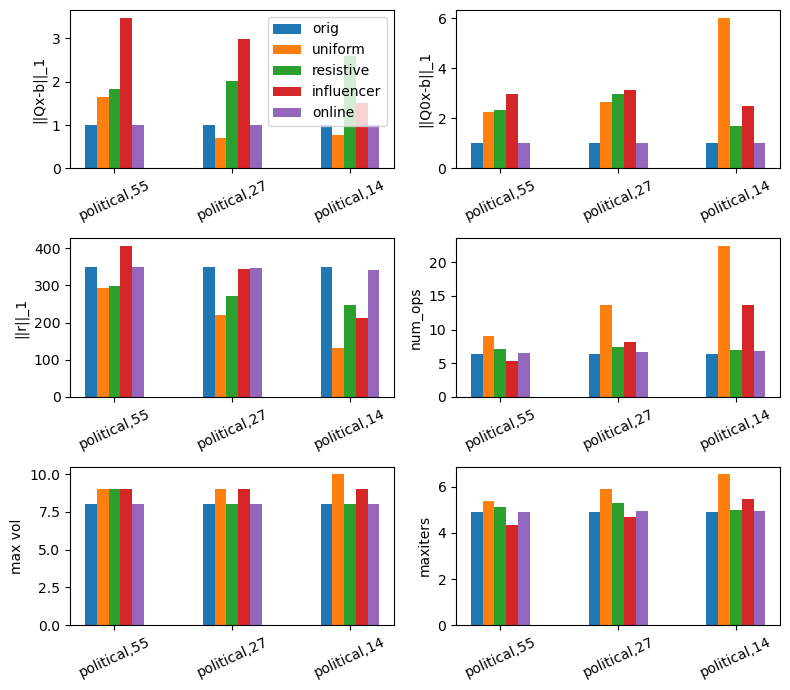

In [52]:
#dataset_list = ['political-blog' , 'citeseer', 'cora', 'mnist-tr-nei10']#, 'pubmed', 'blogcatalog', 'youtube', 'ogbn-arxiv']


trial = 0
beta = 0.25
alpha = 1 - 2*beta


epsilon = 0.001

        
sparse_list = ['orig','influencer','uniform', 'online','resistive']
#sparse_list = ['orig', 'online']
splevel_list = [2,1,.5]

plot_list = ['||Qx-b||_1','||Q0x-b||_1','||r||_1', 'num_ops','max vol','maxiters']

errs = np.zeros((len(dataset_list)*len(splevel_list),len(sparse_list), 6))  # 3D array to hold misclassification data


xlabels = [None for k in range(len(dataset_list)*len(splevel_list))]
for d,dataset in enumerate(dataset_list):
     
    mat = {}
    
    adj_matrix_orig, labels = load_graph_data(dataset)
    if not isinstance(adj_matrix_orig, csr_matrix):
        adj_matrix_orig = csr_matrix(adj_matrix_orig)        
    n = len(labels)
    y_nnz_len = n
    num_classes = max(labels)+1
    
    for sl,sparselevel in enumerate(splevel_list): 
        
        node_degrees = adj_matrix_orig.getnnz(axis=1)
        c = int(np.round(np.mean(node_degrees)*sparselevel))
        print(c)
        if c == 0: continue
        for s,sparse in enumerate(sparse_list):
            if not (sparse == 'orig'):

                if sparse == 'influencer':
                    spmat_string = '%s_sparse%s_c%d_spmat' % (dataset,sparse,c)
                elif sparse == 'uniform' or sparse == 'resistive':
                    p = np.round(100*mat['influencer'].nnz / mat['orig'].nnz)/100
                    spmat_string = '%s_sparse%s_p%f_spmat' % (dataset,sparse,p)
 

                adj_matrix = pickle.load(open('offline_sparsify/%s.pkl' % spmat_string,'rb'))
            elif sparse == 'orig':
                adj_matrix = adj_matrix_orig
            mat[sparse] = adj_matrix     

     
 

    

            if sparse == 'orig':
                expstring = '%s_beta%f_sparse%s_eps%e_ynnz%d' % (dataset,beta,'orig',epsilon,y_nnz_len)
            elif sparse == 'influencer':
                expstring = '%s_beta%f_sparse%s_c%d_eps%e_ynnz%d' % (dataset,beta,sparse,c,epsilon,y_nnz_len)
            elif sparse == 'online':
                expstring = '%s_beta%f_onlinesparse_c%d_eps%e_ynnz%d' % (dataset,beta,c,epsilon,y_nnz_len)

            else:
                expstring = '%s_beta%f_sparse%s_p%f_eps%e_ynnz%d' % (dataset,beta,sparse,p,epsilon,y_nnz_len)

            try:
                out = pickle.load(open('offline_APPR/%s.pkl' % expstring,'rb'))
            except:
                continue

            errs[d*len(splevel_list)+sl,s,0] =  np.linalg.norm(out['r'],1)
            if 'r_orig' in out.keys():
                errs[d*len(splevel_list)+sl,s,1] =  np.linalg.norm(out['r_orig'],1)
            else:

                errs[d*len(splevel_list)+sl,s,1] =  np.linalg.norm(out['r'],1)
            errs[d*len(splevel_list)+sl,s,2] =  np.linalg.norm(out['err_r'],1)
            errs[d*len(splevel_list)+sl,s,3] =  np.mean(out['num_ops_list'])
            errs[d*len(splevel_list)+sl,s,4] =  np.max([len(v) for v in out['volrs'] ])
            errs[d*len(splevel_list)+sl,s,5] = np.mean(out['maxiters'])


            xlabels[d*len(splevel_list)+sl] = dataset.split('-')[0] + ',' + str(c)

 
num_datasets_splevel = errs.shape[0]
num_sparse = errs.shape[1]
num_plots = errs.shape[2]

# Width of the bars
bar_width = 0.1

# Setting up the figure
fig, axs = plt.subplots(3, 2, figsize=(8,  7))
axs = axs.flatten()

# X axis positions for each beta, adjusted for each sparse list index
x_positions = np.arange(num_datasets_splevel)

sidx_list = [0,2,4,1,3]
for m in range(num_plots):
    ax = axs[m] 
    
    for si in range(len(sidx_list)):
        s = sidx_list[si]
        ax.bar(x_positions + si * bar_width, errs[:,s,m], width=bar_width, label=sparse_list[s])

    
    # Configure the subplot
    ax.set_ylabel(plot_list[m])
    ax.set_xticks(x_positions + bar_width * (num_sparse - 1) / 2)
    ax.set_xticklabels([xlabels[i] for i in range(num_datasets_splevel)], rotation=25)
    if m == 0: ax.legend()
    
    
plt.tight_layout()
plt.savefig('appr_online_smalldataset.png')
asdf

C:\Users\yifan\AppData\Local\Temp\ipykernel_24032\1945346282.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


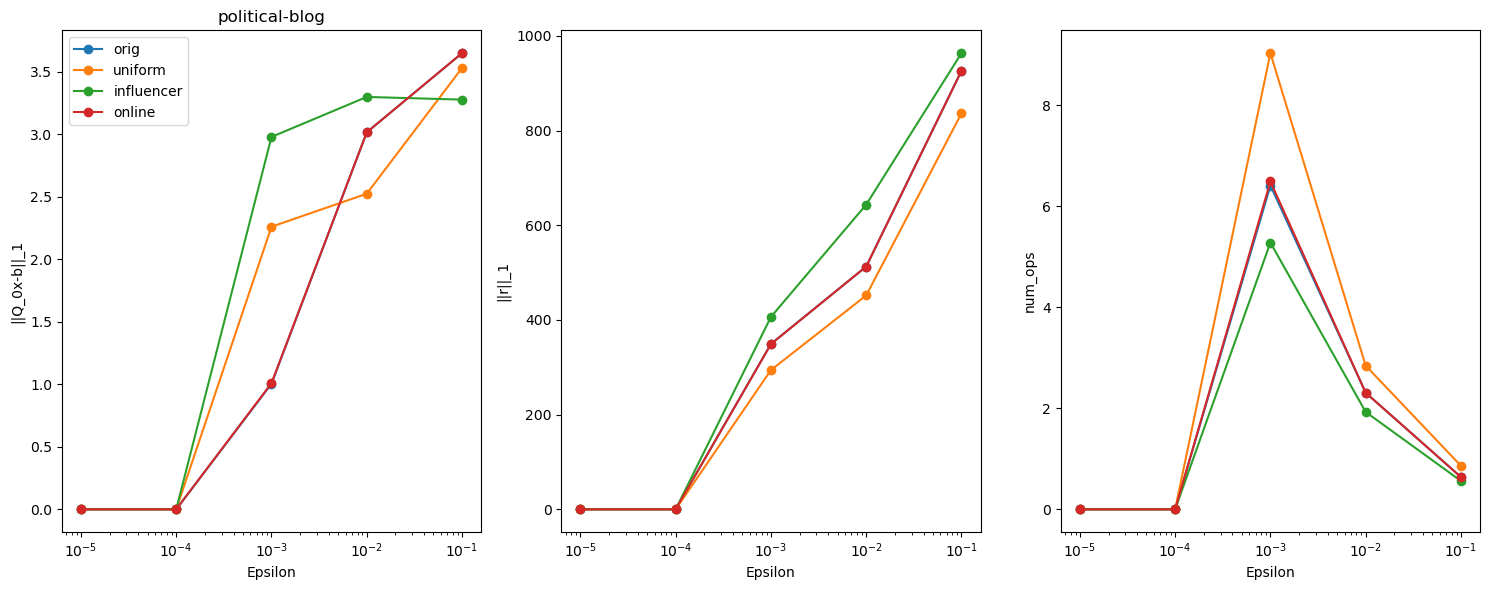

In [51]:



trial = 0
beta = 0.25
alpha = 1 - 2*beta

epsilon_vec = [1.e-1,1.e-2,1.e-3,1.e-4,1.e-5]


sparse_list = ['orig','influencer','uniform', 'online']#,'resistive']

plot_list = ['||Qx-b||_1','||Q_0x-b||_1','||r||_1', 'runtime','max vol','maxiters']
plot_list = ['||Q_0x-b||_1','||r||_1', 'num_ops']

errs = np.zeros((len(dataset_list),len(sparse_list), len(epsilon_vec), 6))  # 3D array to hold misclassification data


xlabels = [None for k in range(len(dataset_list))]
for d,dataset in enumerate(dataset_list):
     
    mat = {}
    
    adj_matrix_orig, labels = load_graph_data(dataset)
    if not isinstance(adj_matrix, csr_matrix):
        adj_matrix = csr_matrix(adj_matrix)        
    n = len(labels)
    y_nnz_len = n
    num_classes = max(labels)+1
    
    for s,sparse in enumerate(sparse_list):
            
        if not (sparse == 'orig'):
            
            if sparse == 'influencer':
                node_degrees = adj_matrix_orig.getnnz(axis=1)
                maxneighbors = int(np.round(np.mean(node_degrees)*2))
                spmat_string = '%s_sparse%s_c%d_spmat' % (dataset,sparse,maxneighbors)
            elif sparse == 'uniform' or sparse == 'resistive':
                p = np.round(100*mat['influencer'].nnz / mat['orig'].nnz)/100
                spmat_string = '%s_sparse%s_p%f_spmat' % (dataset,sparse,p)

            adj_matrix = pickle.load(open('offline_sparsify/%s.pkl' % spmat_string,'rb'))
        elif sparse == 'orig':
            adj_matrix = adj_matrix_orig
        mat[sparse] = adj_matrix     
        
     
 

        for e,epsilon in enumerate(epsilon_vec):


            if sparse == 'orig':
                expstring = '%s_beta%f_sparse%s_eps%e_ynnz%d' % (dataset,beta,'orig',epsilon,y_nnz_len)
            elif sparse == 'influencer':
                expstring = '%s_beta%f_sparse%s_c%d_eps%e_ynnz%d' % (dataset,beta,sparse,maxneighbors,epsilon,y_nnz_len)
            elif sparse == 'online':
                expstring = '%s_beta%f_onlinesparse_c%d_eps%e_ynnz%d' % (dataset,beta,maxneighbors,epsilon,y_nnz_len)

            else:
                expstring = '%s_beta%f_sparse%s_p%f_eps%e_ynnz%d' % (dataset,beta,sparse,p,epsilon,y_nnz_len)

            try:
                out = pickle.load(open('offline_APPR/%s.pkl' % expstring,'rb'))
                
                
                #errs[d,s,e,0] =  np.linalg.norm(out['r'],1)
                if 'r_orig' in out.keys():
                    errs[d,s,e,0] =  np.linalg.norm(out['r_orig'],1)
                else:

                    errs[d,s,e,0] =  np.linalg.norm(out['r'],1)
                errs[d,s,e,1] =  np.linalg.norm(out['err_r'],1)
                errs[d,s,e,2] =  np.mean(out['num_ops_list'] )

            
            except:
                continue



            xlabels[d] = dataset.split('-')[0]

 
num_datasets = errs.shape[0]
num_sparse = errs.shape[1]
num_plots = len(plot_list)

# Width of the bars
bar_width = 0.1

plt.figure( figsize=(15, 2* num_plots))

sidx_list = [0,2,1,3]
for d,dataset in enumerate(dataset_list):
    
    for m in range(num_plots):
        plt.subplot(num_datasets,num_plots,m+num_plots*d+1)
        for si in range(len(sidx_list)):
            s = sidx_list[si]
            plt.semilogx(epsilon_vec, errs[d, s, :, m], marker='o', label=sparse_list[s])


        plt.xlabel('Epsilon')
        plt.ylabel(plot_list[m])
        if m == 0:
            plt.legend()
            plt.title(dataset)

plt.tight_layout()
    
plt.tight_layout()
plt.savefig('appr_online_smalldataset_eps.png')
